In [1]:
from src.FullFeatureSet import FullFeatureSet
from src.ManuallySelectedFeatureSet import ManuallySelectedFeatureSet
from src.PcaFeatureSet import PcaFeatureSet
from src.SomModelRunner import SomModelRunner
from src.uci_har_dataset import UciHarDataset
import itertools

%load_ext autoreload
%autoreload 2

In [2]:
dataset = UciHarDataset()
full_features = FullFeatureSet(dataset)
manual_features= ManuallySelectedFeatureSet(dataset)
pca_features = PcaFeatureSet(dataset, n_components=10)

Loaded activity labels from data/UCI-HAR Dataset//activity_labels.txt
{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
Loaded feature names from data/UCI-HAR Dataset//features.txt
Loaded features from data/UCI-HAR Dataset/train/X_train.txt. Shape: (7352, 561)
Loaded labels from data/UCI-HAR Dataset/train/y_train.txt. Shape: (7352, 1)
Loaded features from data/UCI-HAR Dataset/test/X_test.txt. Shape: (2947, 561)
Loaded labels from data/UCI-HAR Dataset/test/y_test.txt. Shape: (2947, 1)
Selected features: train. Shape: (7352, 15)
Selected features: test. Shape: (2947, 15)
Scaled features using StandardScaler.


In [5]:
feature_configs = {
    "Full (561)": full_features,
    "Manual (15)": manual_features,
    "PCA (80%)": pca_features,
}

param_grid = {
    'grid_size': [4, 6, 8, 10, 20],
    'sigma': [0.2, 0.4, 0.6],
    'lr': [0.5],
}

results = []
all_results = []

for name, f_set in feature_configs.items():
    print(f"\n--- Grid Search: {name} ---")
    best_qe = 100
    best_acc = 0
    best_te = 100
    best_params = None

    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    best_result = {}

    for params in combinations:
        runner = SomModelRunner(
            dataset=dataset,
            feature_set=f_set,
            x_size = params['grid_size'],
            y_size = params['grid_size'],
            sigma = params['sigma'] * params['grid_size'],
            lr = params['lr'],
            name=f"{name} {params}"
        )
        qe, te = runner.run(iterations=5000, num_examples=2000)
        # acc = runner.evaluate_test_set()

        result = {
            'feature_set_name': name,
            'best_accuracy': best_acc,
            'best_te': qe,
            'best_qe': te,
            'best_params': params,
            'feature_set_obj': f_set
        }
        all_results.append(result)

        if qe < best_qe and te < 0.1:
            best_result = result

    results.append(best_result)

print("\n" + "="*30)
print("FINAL RESULTS")
print("="*30)

for res in results:
    print(f"Set: {res['feature_set_name']} | Params: {res['best_params']}")

    # # Re-run the winner with full plots
    # best_svm = SVC(**res['best_params'])
    # final_runner = SvmRunner(dataset, res['feature_set_obj'], best_svm, name=res['feature_set_name'])
    # final_runner.run()
    # # final_runner.plot_confusion_matrix() # Uncomment if you want all plots at once


--- Grid Search: Full (561) ---
[Full (561) {'grid_size': 4, 'sigma': 0.2, 'lr': 0.5}]QE:4.2766 | TE:0.5110 | ACC:0.7838
[Full (561) {'grid_size': 4, 'sigma': 0.4, 'lr': 0.5}]QE:4.3752 | TE:0.1955 | ACC:0.6905
[Full (561) {'grid_size': 4, 'sigma': 0.6, 'lr': 0.5}]QE:4.5566 | TE:0.0835 | ACC:0.7727
[Full (561) {'grid_size': 6, 'sigma': 0.2, 'lr': 0.5}]QE:3.8785 | TE:0.3835 | ACC:0.7530
[Full (561) {'grid_size': 6, 'sigma': 0.4, 'lr': 0.5}]QE:4.2761 | TE:0.1185 | ACC:0.7784
[Full (561) {'grid_size': 6, 'sigma': 0.6, 'lr': 0.5}]QE:4.4612 | TE:0.0475 | ACC:0.7479
[Full (561) {'grid_size': 8, 'sigma': 0.2, 'lr': 0.5}]QE:3.7892 | TE:0.2660 | ACC:0.7360
[Full (561) {'grid_size': 8, 'sigma': 0.4, 'lr': 0.5}]QE:4.2063 | TE:0.0930 | ACC:0.7910
[Full (561) {'grid_size': 8, 'sigma': 0.6, 'lr': 0.5}]QE:4.3829 | TE:0.0665 | ACC:0.7879
[Full (561) {'grid_size': 10, 'sigma': 0.2, 'lr': 0.5}]QE:3.6901 | TE:0.2450 | ACC:0.8090
[Full (561) {'grid_size': 10, 'sigma': 0.4, 'lr': 0.5}]QE:4.1576 | TE:0.0900

PCA
[Runner]QE:2.4483 | TE:0.0510 | ACC:0.7475


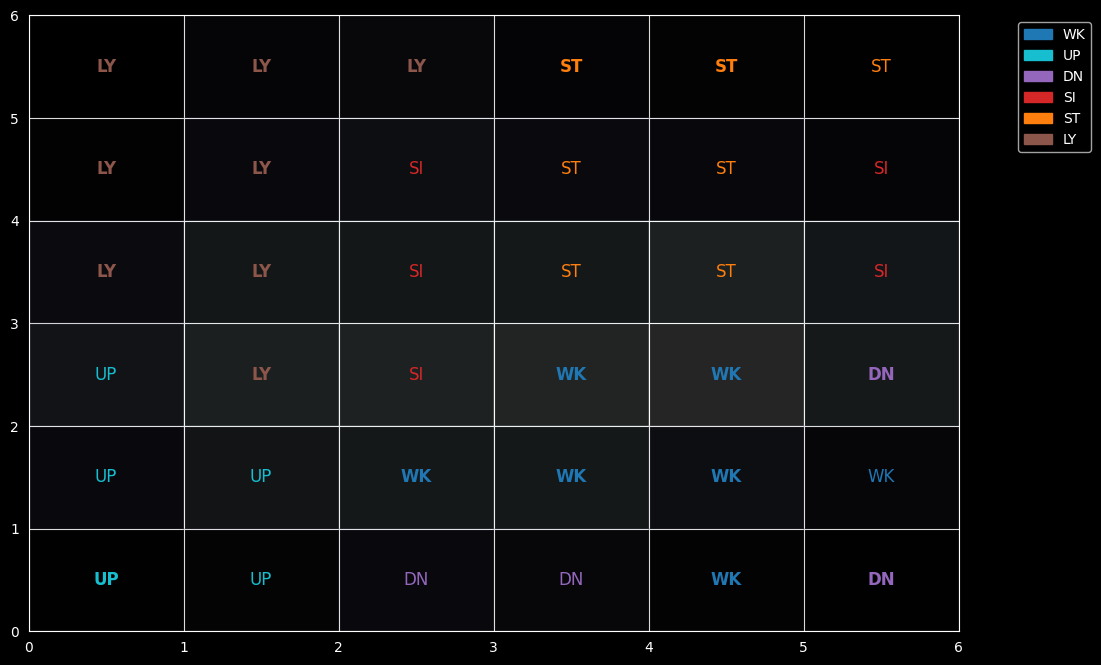

--- Purity Report for Runner ---
Average Neuron Purity: 0.8042
Percentage of 'Pure' Neurons (>90% same label): 30.56%
[Runner]QE:2.8049 | TE:0.1502 | ACC:0.6098
--- Purity Report for Runner ---
Average Neuron Purity: 0.7714
Percentage of 'Pure' Neurons (>90% same label): 31.25%


In [40]:
print("PCA")
runner = SomModelRunner(dataset, feature_set=pca_features,
                        x_size=6,
                        y_size=6,
                        sigma=2.4,
                        lr=0.5,
                        topology='rectangular')
runner.run(iterations=5000)
runner.plot_labeled_grid(filename='fig/som_pca_labeled_grid.svg')
runner.evaluate_test_set()
runner.check_cluster_purity()

runner = SomModelRunner(dataset, feature_set=pca_features,
                        x_size=4,
                        y_size=4,
                        sigma=1.6,
                        lr=0.5,
                        topology='rectangular')
runner.run(iterations=5000)
# runner.plot_labeled_grid()
runner.evaluate_test_set()
runner.check_cluster_purity()

In [34]:
print("FULL")

runner = SomModelRunner(dataset, feature_set=full_features,
                        x_size=6,
                        y_size=6,
                        sigma=3.6,
                        lr=0.5,
                        topology='rectangular')
runner.run(iterations=5000)
# runner.plot_labeled_grid()
runner.evaluate_test_set()
runner.check_cluster_purity()

runner = SomModelRunner(dataset, feature_set=full_features,
                        x_size=4,
                        y_size=4,
                        sigma=2.4,
                        lr=0.5,
                        topology='rectangular')
runner.run(iterations=5000)
# runner.plot_labeled_grid()
runner.evaluate_test_set()
runner.check_cluster_purity()

FULL
[Runner]QE:4.6749 | TE:0.1538 | ACC:0.6583
--- Purity Report for Runner ---
Average Neuron Purity: 0.8038
Percentage of 'Pure' Neurons (>90% same label): 47.22%
[Runner]QE:4.9060 | TE:0.2791 | ACC:0.6298
--- Purity Report for Runner ---
Average Neuron Purity: 0.7762
Percentage of 'Pure' Neurons (>90% same label): 43.75%


In [35]:
runner = SomModelRunner(dataset, feature_set=manual_features,
                        x_size=6,
                        y_size=6,
                        sigma=2.4,
                        lr=0.5,
                        topology='rectangular')
runner.run(iterations=5000)
# runner.plot_labeled_grid()
runner.evaluate_test_set()
runner.check_cluster_purity()
runner = SomModelRunner(dataset, feature_set=manual_features,
                        x_size=4,
                        y_size=4,
                        sigma=1.6,
                        lr=0.5,
                        topology='rectangular')
runner.run(iterations=5000)
# runner.plot_labeled_grid()
runner.evaluate_test_set()
runner.check_cluster_purity()



[Runner]QE:1.6608 | TE:0.0585 | ACC:0.6922
--- Purity Report for Runner ---
Average Neuron Purity: 0.7484
Percentage of 'Pure' Neurons (>90% same label): 27.78%
[Runner]QE:1.8336 | TE:0.0411 | ACC:0.6230
--- Purity Report for Runner ---
Average Neuron Purity: 0.7187
Percentage of 'Pure' Neurons (>90% same label): 25.00%
